In [2]:
import pandas as pd
import numpy as np

In [3]:
print(f"pandas version {pd.__version__}")

pandas version 1.1.4


In [4]:
print(f"numpy version {np.__version__}")

numpy version 1.19.4


# Récupération des données

In [5]:
# load data from internet
import requests
url = 'https://s3.amazonaws.com/tripdata/201306-citibike-tripdata.zip'
r = requests.get(url, allow_redirects=True)

In [6]:
type(r.content) # ce sont des données brutes (ici un zip)

bytes

In [7]:
import zipfile
import io

In [8]:
zfile = zipfile.ZipFile(io.BytesIO(r.content))

In [9]:
zfile.infolist()[0] # c'est bien le fichier que nous voulons

<ZipInfo filename='201306-citibike-tripdata.csv' compress_type=deflate filemode='-rw-r--r--' external_attr=0x4000 file_size=100938999 compress_size=16784474>

In [10]:
content = zfile.read(zfile.infolist()[0])

In [11]:
data=pd.read_csv(io.StringIO(content.decode('utf-8')))

In [12]:
data # petit coup d'oeil sur les données récupérées

tripduration            starttime             stoptime  \
0                695  2013-06-01 00:00:01  2013-06-01 00:11:36   
1                693  2013-06-01 00:00:08  2013-06-01 00:11:41   
2               2059  2013-06-01 00:00:44  2013-06-01 00:35:03   
3                123  2013-06-01 00:01:04  2013-06-01 00:03:07   
4               1521  2013-06-01 00:01:22  2013-06-01 00:26:43   
...              ...                  ...                  ...   
577698           925  2013-06-30 23:59:27  2013-07-01 00:14:52   
577699           279  2013-06-30 23:59:36  2013-07-01 00:04:15   
577700           161  2013-06-30 23:59:33  2013-07-01 00:02:14   
577701           909  2013-06-30 23:59:47  2013-07-01 00:14:56   
577702           634  2013-07-01 00:00:00  2013-07-01 00:10:34   

        start station id      start station name  start station latitude  \
0                    444      Broadway & W 24 St               40.742354   
1                    444      Broadway & W 24 St               40.742354   
2                    406  Hicks St & Montague St               40.695128   
3                    475     E 15 St & Irving Pl               40.735243   
4                   2008   Little West St & 1 Pl               40.705693   
...                  ...                     ...                     ...   
577698               509         9 Ave & W 22 St               40.745497   
577699               116         W 17 St & 8 Ave               40.741776   
577700               443    Bedford Ave & S 9 St               40.708531   
577701               509         9 Ave & W 22 St               40.745497   
577702               164         E 47 St & 2 Ave               40.753231   

        start station longitude  end station id        end station name  \
0                    -73.989151           434.0         9 Ave & W 18 St   
1                    -73.989151           434.0         9 Ave & W 18 St   
2                    -73.995951           406.0  Hicks St & Montague St   
3                    -73.987586           262.0         Washington Park   
4                    -74.016777           310.0     State St & Smith St   
...                         ...             ...                     ...   
577698               -74.001971           462.0        W 22 St & 10 Ave   
577699               -74.001497           494.0         W 26 St & 8 Ave   
577700               -73.964090           282.0      Kent Ave & S 11 St   
577701               -74.001971           462.0        W 22 St & 10 Ave   
577702               -73.970325           504.0         1 Ave & E 16 St   

        end station latitude  end station longitude  bikeid    usertype  \
0                  40.743174             -74.003664   19678  Subscriber   
1                  40.743174             -74.003664   16649  Subscriber   
2                  40.695128             -73.995951   19599    Customer   
3                  40.691782             -73.973730   16352  Subscriber   
4                  40.689269             -73.989129   15567  Subscriber   
...                      ...                    ...     ...         ...   
577698             40.746920             -74.004519   15250  Subscriber   
577699             40.747348             -73.997236   19411    Customer   
577700             40.707645             -73.968415   18910  Subscriber   
577701             40.746920             -74.004519   16108    Customer   
577702             40.732219             -73.981656   16950    Customer   

        birth year  gender  
0           1983.0       1  
1           1984.0       1  
2              NaN       0  
3           1960.0       1  
4           1983.0       1  
...            ...     ...  
577698      1964.0       1  
577699         NaN       0  
577700      1972.0       2  
577701         NaN       0  
577702         NaN       0  

[577703 rows x 15 columns]

# Comptons la proportion d'abonnés

In [42]:
usertype_counts=data['usertype'].value_counts()
usertype_counts

Subscriber    337384
Customer      240319
Name: usertype, dtype: int64

In [50]:
data.count()['usertype'] # nombre de valeurs dans la colonne usertype

577703

In [51]:
data.shape # un autre moyen d'avoir le nombre de lignes (/!\ aux données manquantes)

(577703, 15)

In [56]:
subpart=usertype_counts['Subscriber']/data.count()['usertype']
subpart

0.5840094304512873

In [65]:
print(f"Il y a {100*subpart:.2f}% dabonnés")

Il y a 58.40% dabonnés


# Calcul de la distance des trajets
En considérant des distances en ligne droite entre la station de départ et celle d'arrivée

In [15]:
# on va s'entrainer avec la première données 
# pour le calcul de la distance à partir de coordonnées GPS
data0 = data.iloc[0]
data0

tripduration                               695
starttime                  2013-06-01 00:00:01
stoptime                   2013-06-01 00:11:36
start station id                           444
start station name          Broadway & W 24 St
start station latitude                 40.7424
start station longitude               -73.9892
end station id                             434
end station name               9 Ave & W 18 St
end station latitude                   40.7432
end station longitude                 -74.0037
bikeid                                   19678
usertype                            Subscriber
birth year                                1983
gender                                       1
Name: 0, dtype: object

In [16]:
import math

Pour les calculs de distance à partir de coordonnées GPS, voici quelques inspirations:
* http://www.movable-type.co.uk/scripts/latlong.html
* https://stackoverflow.com/questions/365826/calculate-distance-between-2-gps-coordinates
* https://janakiev.com/blog/gps-points-distance-python

In [17]:
def distanceInKmBetweenEarthCoordinates(lat1, lon1, lat2, lon2):
    earthRadiusKm = 6371

    dLat = math.radians(lat2-lat1)
    dLon = math.radians(lon2-lon1)

    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)

    a = math.sin(dLat/2)**2 + math.sin(dLon/2)**2 * math.cos(lat1) * math.cos(lat2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    return earthRadiusKm * c

In [18]:
# test trivial
distanceInKmBetweenEarthCoordinates(0,0,0,0)

0.0

In [19]:
# test référencé
distanceInKmBetweenEarthCoordinates(51.5, 0, 38.8, -77.1) # From London to Arlington

5918.185064088764

In [20]:
# les attributs contiennent des espaces; 
# on va plutôt utiliser la syntaxe data['attr with space']
data0['start station latitude']

40.742354299999995

In [21]:
distanceInKmBetweenEarthCoordinates(data0['start station latitude'], 
                                    data0['start station longitude'],
                                    data0['end station latitude'],
                                    data0['end station longitude'])

1.2261231411049283

## On est prêt à utiliser cette formule pour insérer une nouvelle colonne 'distance'

In [73]:
data['distance']=data.apply(lambda row: distanceInKmBetweenEarthCoordinates(
                                    row['start station latitude'], 
                                    row['start station longitude'],
                                    row['end station latitude'],
                                    row['end station longitude']), axis=1)

In [74]:
data

tripduration            starttime             stoptime  \
0                695  2013-06-01 00:00:01  2013-06-01 00:11:36   
1                693  2013-06-01 00:00:08  2013-06-01 00:11:41   
2               2059  2013-06-01 00:00:44  2013-06-01 00:35:03   
3                123  2013-06-01 00:01:04  2013-06-01 00:03:07   
4               1521  2013-06-01 00:01:22  2013-06-01 00:26:43   
...              ...                  ...                  ...   
577698           925  2013-06-30 23:59:27  2013-07-01 00:14:52   
577699           279  2013-06-30 23:59:36  2013-07-01 00:04:15   
577700           161  2013-06-30 23:59:33  2013-07-01 00:02:14   
577701           909  2013-06-30 23:59:47  2013-07-01 00:14:56   
577702           634  2013-07-01 00:00:00  2013-07-01 00:10:34   

        start station id      start station name  start station latitude  \
0                    444      Broadway & W 24 St               40.742354   
1                    444      Broadway & W 24 St               40.742354   
2                    406  Hicks St & Montague St               40.695128   
3                    475     E 15 St & Irving Pl               40.735243   
4                   2008   Little West St & 1 Pl               40.705693   
...                  ...                     ...                     ...   
577698               509         9 Ave & W 22 St               40.745497   
577699               116         W 17 St & 8 Ave               40.741776   
577700               443    Bedford Ave & S 9 St               40.708531   
577701               509         9 Ave & W 22 St               40.745497   
577702               164         E 47 St & 2 Ave               40.753231   

        start station longitude  end station id        end station name  \
0                    -73.989151           434.0         9 Ave & W 18 St   
1                    -73.989151           434.0         9 Ave & W 18 St   
2                    -73.995951           406.0  Hicks St & Montague St   
3                    -73.987586           262.0         Washington Park   
4                    -74.016777           310.0     State St & Smith St   
...                         ...             ...                     ...   
577698               -74.001971           462.0        W 22 St & 10 Ave   
577699               -74.001497           494.0         W 26 St & 8 Ave   
577700               -73.964090           282.0      Kent Ave & S 11 St   
577701               -74.001971           462.0        W 22 St & 10 Ave   
577702               -73.970325           504.0         1 Ave & E 16 St   

        end station latitude  end station longitude  bikeid    usertype  \
0                  40.743174             -74.003664   19678  Subscriber   
1                  40.743174             -74.003664   16649  Subscriber   
2                  40.695128             -73.995951   19599    Customer   
3                  40.691782             -73.973730   16352  Subscriber   
4                  40.689269             -73.989129   15567  Subscriber   
...                      ...                    ...     ...         ...   
577698             40.746920             -74.004519   15250  Subscriber   
577699             40.747348             -73.997236   19411    Customer   
577700             40.707645             -73.968415   18910  Subscriber   
577701             40.746920             -74.004519   16108    Customer   
577702             40.732219             -73.981656   16950    Customer   

        birth year  gender  distance  
0           1983.0       1  1.226123  
1           1984.0       1  1.226123  
2              NaN       0  0.000000  
3           1960.0       1  4.971683  
4           1983.0       1  2.961038  
...            ...     ...       ...  
577698      1964.0       1  0.266585  
577699         NaN       0  0.716115  
577700      1972.0       2  0.377679  
577701         NaN       0  0.266585  
577702         NaN       0  2.523943  

[577703 rows x 16 columns]

In [80]:
data['distance'].describe() # qu'a-t-on obtenu avec cette nouvelle colonne

count    559644.000000
mean          2.210706
std           1.688271
min           0.000000
25%           0.984350
50%           1.784102
75%           3.040231
max          14.054339
Name: distance, dtype: float64

Le nombre de lignes avec une distance n'est pas le nombre total de lignes

In [158]:
# Il y a en effet des lignes avec des NaN (car les positions des stations sont en NaN)
data[data['distance'].isna()]

tripduration            starttime             stoptime  \
56               547  2013-06-01 00:11:04  2013-06-01 00:20:11   
102              537  2013-06-01 00:40:27  2013-06-01 00:49:24   
120              472  2013-06-01 00:47:51  2013-06-01 00:55:43   
211              153  2013-06-01 01:32:55  2013-06-01 01:35:28   
289              841  2013-06-01 02:28:10  2013-06-01 02:42:11   
...              ...                  ...                  ...   
577559           357  2013-06-30 23:34:43  2013-06-30 23:40:40   
577598           702  2013-06-30 23:41:28  2013-06-30 23:53:10   
577622           472  2013-06-30 23:44:15  2013-06-30 23:52:07   
577635          1263  2013-06-30 23:47:47  2013-07-01 00:08:50   
577642          1108  2013-06-30 23:50:04  2013-07-01 00:08:32   

        start station id      start station name  start station latitude  \
56                   432       E 7 St & Avenue A               40.726218   
102                  482         W 15 St & 7 Ave               40.739355   
120                  528         2 Ave & E 31 St               40.742909   
211                  284   Greenwich Ave & 8 Ave               40.739017   
289                  509         9 Ave & W 22 St               40.745497   
...                  ...                     ...                     ...   
577559               174         E 25 St & 1 Ave               40.738177   
577598               237         E 11 St & 2 Ave               40.730473   
577622               439          E 4 St & 2 Ave               40.726281   
577635               472      E 32 St & Park Ave               40.745712   
577642               311  Norfolk St & Broome St               40.717227   

        start station longitude  end station id end station name  \
56                   -73.983799             NaN              NaN   
102                  -73.999318             NaN              NaN   
120                  -73.977061             NaN              NaN   
211                  -74.002638             NaN              NaN   
289                  -74.001971             NaN              NaN   
...                         ...             ...              ...   
577559               -73.977387             NaN              NaN   
577598               -73.986724             NaN              NaN   
577622               -73.989780             NaN              NaN   
577635               -73.981948             NaN              NaN   
577642               -73.988021             NaN              NaN   

        end station latitude  end station longitude  bikeid    usertype  \
56                       NaN                    NaN   17470  Subscriber   
102                      NaN                    NaN   15090  Subscriber   
120                      NaN                    NaN   16257  Subscriber   
211                      NaN                    NaN   20106  Subscriber   
289                      NaN                    NaN   18792    Customer   
...                      ...                    ...     ...         ...   
577559                   NaN                    NaN   19258  Subscriber   
577598                   NaN                    NaN   17208    Customer   
577622                   NaN                    NaN   17565  Subscriber   
577635                   NaN                    NaN   16576  Subscriber   
577642                   NaN                    NaN   16694    Customer   

        birth year  gender  distance  
56          1980.0       1       NaN  
102         1981.0       1       NaN  
120         1965.0       1       NaN  
211         1987.0       1       NaN  
289            NaN       0       NaN  
...            ...     ...       ...  
577559      1986.0       1       NaN  
577598         NaN       0       NaN  
577622      1963.0       1       NaN  
577635      1956.0       1       NaN  
577642         NaN       0       NaN  

[18059 rows x 16 columns]

In [159]:
max_distance = data['distance'].describe()['max']
print(f"La distance maximale parcourue est de {max_distance:.2f}km")

La distance maximale parcourue est de 14.05km


# Faisons quelques statistiques sur les genres et les heures

In [160]:
data['gender'].value_counts()

1    263492
0    240748
2     73463
Name: gender, dtype: int64

Attention, `gender=0` correspond à des clients dont on ne connait pas le genre. 
Nous allons donc les exclures d'un traitement par genre.

Rappel de la doc (https://www.citibikenyc.com/system-data)
```
Gender (Zero=unknown; 1=male; 2=female)
```
Il y a donc beaucoup plus d'hommes inscrits que de femmes.

In [161]:
# Statistiques synthétiques pour les hommes
data[data['gender']==1]['distance'].describe()

count    255339.000000
mean          2.183920
std           1.698763
min           0.000000
25%           0.945901
50%           1.702063
75%           2.996451
max          14.054339
Name: distance, dtype: float64

In [162]:
# Statistiques synthétiques pour les femmes
data[data['gender']==2]['distance'].describe()

count    71090.000000
mean         2.202133
std          1.658049
min          0.000000
25%          0.989217
50%          1.763925
75%          3.034607
max         13.711386
Name: distance, dtype: float64

Les femmes font (tant en moyenne que par les quartiles) des trajets plus longs

Pour les regroupements par heures, nous allons le faire en nous basant sur l'heure de début

In [170]:
# Quelle est la nature des données de la colonne starttime ?
# data.dtypes['starttime']
data.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id             float64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                 float64
gender                       int64
distance                   float64
dtype: object

In [171]:
type(data.iloc[56]['starttime'])

str

Ce sont des strings, il faut les convertir

In [180]:
starttime_as_datetime = pd.to_datetime(data['starttime'])

In [181]:
starttime_as_datetime.dtypes

dtype('<M8[ns]')

C'est mieux, ce sont bien des dates. On les injecte dans le `data`

In [182]:
data['starttime']=starttime_as_datetime

In [203]:
# on fait de même pour l'heure de fin
data['stoptime']=pd.to_datetime(data['stoptime'])

In [204]:
data.dtypes # on vérifie le type

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                    float64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
birth year                        float64
gender                              int64
distance                          float64
dtype: object

In [186]:
group_by_hour = data.groupby(by=[data.starttime.map(lambda x: x.hour)])

In [188]:
group_by_hour['distance'].describe()

count      mean       std  min       25%       50%       75%  \
starttime                                                                   
0           7528.0  2.170664  1.707858  0.0  0.935406  1.771992  3.007894   
1           4235.0  2.153294  1.688195  0.0  0.945289  1.771074  2.968166   
2           2664.0  2.135061  1.767576  0.0  0.908553  1.696658  2.871721   
3           1563.0  2.026308  1.565440  0.0  0.892308  1.648457  2.841767   
4           1133.0  2.121610  1.648904  0.0  0.919184  1.762361  2.985742   
5           1875.0  2.276975  1.803522  0.0  0.940061  1.806914  3.145417   
6           6884.0  2.389658  1.795655  0.0  1.074955  1.904888  3.257632   
7          15505.0  2.405368  1.760613  0.0  1.119458  1.903993  3.290112   
8          31105.0  2.370589  1.687973  0.0  1.131667  1.907729  3.220818   
9          28122.0  2.238909  1.688673  0.0  1.039531  1.767930  3.031090   
10         22379.0  2.167496  1.692133  0.0  0.943476  1.707621  3.001404   
11         26367.0  2.153117  1.669881  0.0  0.927469  1.709929  2.985067   
12         33753.0  2.117498  1.692149  0.0  0.904350  1.668386  2.906450   
13         36935.0  2.100751  1.673833  0.0  0.898860  1.667061  2.876688   
14         36980.0  2.135383  1.663973  0.0  0.919566  1.717300  2.952683   
15         36992.0  2.150852  1.666171  0.0  0.940451  1.734639  2.970700   
16         39829.0  2.206943  1.678316  0.0  0.992788  1.784564  3.028462   
17         51669.0  2.295432  1.704197  0.0  1.053258  1.869964  3.139989   
18         52300.0  2.291757  1.701456  0.0  1.038042  1.879360  3.157541   
19         41753.0  2.229030  1.672207  0.0  0.999356  1.830885  3.068833   
20         30951.0  2.174389  1.664883  0.0  0.949916  1.783201  3.012905   
21         21035.0  2.160756  1.671928  0.0  0.948662  1.751011  2.984187   
22         16383.0  2.155032  1.669412  0.0  0.936768  1.756303  2.953261   
23         11704.0  2.171537  1.690451  0.0  0.933811  1.770256  3.032959   

                 max  
starttime             
0          12.800832  
1          14.043647  
2          13.682428  
3           9.572372  
4          11.387151  
5          13.690258  
6          13.545395  
7          13.024455  
8          13.494990  
9          14.054339  
10         13.711386  
11         13.474349  
12         13.917669  
13         14.054339  
14         13.682428  
15         14.043647  
16         13.711386  
17         13.711386  
18         13.721331  
19         13.977455  
20         13.682428  
21         14.043647  
22         13.345723  
23         12.790644

Avec des graphiques, cela sera plus parlant

In [198]:
group_by_hour['distance'].sum().plot(kind='bar')

<AxesSubplot:xlabel='starttime'>

In [199]:
group_by_hour['distance'].count().plot(kind='bar')

<AxesSubplot:xlabel='starttime'>

In [200]:
group_by_hour['distance'].mean().plot(kind='bar')

<AxesSubplot:xlabel='starttime'>

## Bonus: et la vitesse moyenne change-t-elle avec l'heure de la journée ?

In [234]:
speed_by_hour = (data['distance']/(data['tripduration']/3600)) \
    .groupby(by=[data.starttime.map(lambda x: x.hour)])

In [235]:
speed_by_hour.mean().plot.bar()

<AxesSubplot:xlabel='starttime'>

On dirait bien que le matin, le _monde_ est plus _pressé_ que le reste de la journée...

Mais attention à la variabilité des données !

<AxesSubplot:xlabel='starttime'>

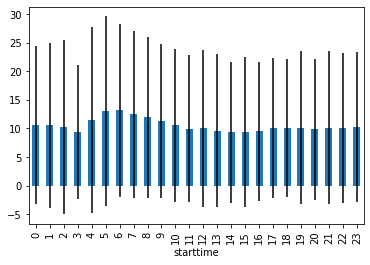

In [236]:
speed_by_hour.mean().plot.bar(yerr=speed_by_hour.std())

L'erreur est énorme et même supérieure aux données (ici les vitesses) elles-mêmes...

Nous aurions peut-être intérêt à filter les valeurs aberrantes

In [237]:
speed_by_hour.describe() # il en faut du muscles pour réaliser des vitesses moyennes supérieures à 200km/h...

count       mean        std  min       25%       50%        75%  \
starttime                                                                      
0           7528.0  10.651371  13.786554  0.0  4.765352  7.668019  11.030895   
1           4235.0  10.548957  14.417659  0.0  4.485865  7.604640  10.991981   
2           2664.0  10.270684  15.251493  0.0  4.139042  7.635018  10.885431   
3           1563.0   9.398612  11.774515  0.0  3.864725  7.397308  10.771409   
4           1133.0  11.429139  16.270039  0.0  3.894665  7.797604  11.973778   
5           1875.0  12.981660  16.594105  0.0  6.536193  9.687274  13.275995   
6           6884.0  13.186037  15.098768  0.0  7.398249  9.899568  13.194033   
7          15505.0  12.447639  14.528960  0.0  7.094009  9.390854  12.307221   
8          31105.0  11.918569  14.158719  0.0  6.644265  8.845856  11.606390   
9          28122.0  11.338261  13.493208  0.0  5.996475  8.387484  11.260908   
10         22379.0  10.532219  13.446715  0.0  4.978206  7.708824  10.747960   
11         26367.0   9.934111  12.845178  0.0  4.633711  7.338667  10.343996   
12         33753.0   9.997509  13.720195  0.0  4.427118  7.101590  10.112622   
13         36935.0   9.629484  13.362687  0.0  4.321958  6.916244   9.898965   
14         36980.0   9.347699  12.313422  0.0  4.129214  6.839002   9.826723   
15         36992.0   9.405924  13.049972  0.0  4.201838  6.900550   9.842894   
16         39829.0   9.512884  12.124801  0.0  4.451068  7.154329  10.136956   
17         51669.0  10.060135  12.209925  0.0  5.080108  7.612719  10.567485   
18         52300.0  10.097170  12.006905  0.0  5.138948  7.733722  10.672621   
19         41753.0  10.153472  13.379321  0.0  4.956488  7.567789  10.566576   
20         30951.0   9.829525  12.387695  0.0  4.669283  7.344167  10.401401   
21         21035.0  10.131537  13.422328  0.0  4.747302  7.417529  10.574190   
22         16383.0  10.072766  13.105227  0.0  4.678168  7.462422  10.572203   
23         11704.0  10.241020  13.158049  0.0  4.741553  7.638248  10.892345   

                  max  
starttime              
0          241.404427  
1          226.853076  
2          298.267909  
3          250.933549  
4          183.695483  
5          230.267913  
6          288.300710  
7          444.004196  
8          514.694507  
9          390.039730  
10         305.682521  
11         339.360708  
12         291.388879  
13         374.249574  
14         312.686921  
15         653.175079  
16         364.947499  
17         308.788217  
18         325.287957  
19         503.730351  
20         283.303960  
21         380.477180  
22         318.274688  
23         208.357224

In [238]:
# on ajoute une colonne 'speed' aux données (km/h)
data['speed'] = data['distance']/(data['tripduration']/3600)

<AxesSubplot:xlabel='speed'>

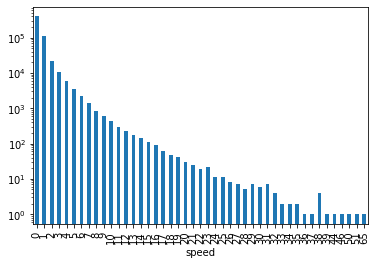

In [299]:
# Voyons le profil des vitesses (non NaN)
# on fait un diagramme à bar regroupant les vitesses par intervalles de 10km/h (on affiche le 'count()')
non_nan_speed = data[(~data.speed.isna())].speed
non_nan_speed.groupby(by=[non_nan_speed.map(lambda x: int(x/10))]) \
  .count() \
  .plot(kind='bar', logy=True)

In [301]:
# On va filtrer les vitesses supérieurs à 50km/h (arbitrairement; on pourrait aussi )
data[data.speed > 50][['tripduration', 'distance', 'speed']].describe()

tripduration      distance         speed
count  10438.000000  10438.000000  10438.000000
mean     275.436865      5.497696     79.470041
std      123.484671      2.111235     37.470951
min       61.000000      0.913694     50.000102
25%      187.000000      3.976075     56.828523
50%      257.000000      5.139224     67.127318
75%      344.000000      6.754945     87.446433
max      991.000000     14.054339    653.175079

In [302]:
speed_by_hour2 = data[data.speed <= 50].speed.groupby(by=[data.starttime.map(lambda x: x.hour)])

In [303]:
speed_by_hour2.mean().plot.bar(yerr=speed_by_hour2.std())

<AxesSubplot:xlabel='starttime'>

Il y a encore une grosse variabilité, mais c'est déjà mieux.

Le jeu de données contient pas mal de données extrêmes.

In [304]:
(data['stoptime']-data['starttime']).describe()

count                       577703
mean     0 days 00:22:52.570279191
std      0 days 02:30:28.063032723
min                0 days 00:01:01
25%                0 days 00:08:34
50%                0 days 00:14:34
75%                0 days 00:23:18
max               44 days 20:47:59
dtype: object

On voit ici une location de 44 jours. Au regard de la moyenne, c'est aussi une valeur aberrante.

## Quel velo a parcouru la plus grande distance ?

In [312]:
data.groupby('bikeid')['distance'].sum().describe()

count    5794.000000
mean      213.532638
std        83.130173
min         0.000000
25%       160.609903
50%       222.790830
75%       272.544366
max       441.447315
Name: distance, dtype: float64

Près de 6000 vélos avec une moyenne par vélo de 213km (sur un mois).

In [314]:
# Et voici le vélo qui a parcouru la plus grande distance
data.groupby('bikeid')['distance'].sum().nlargest(1)

bikeid
18338    441.447315
Name: distance, dtype: float64